# Assignment-1 (SMAI) 
### Akshit Sharma (2021101029)

### Importing modules

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,f1_score,hamming_loss,multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
import time
from sklearn.tree import DecisionTreeClassifier
from prettytable import PrettyTable
from sklearn.model_selection import KFold

### KNN Class Implementation

In [236]:
class KNN:
    def __init__(self,encoder_type,K,distance_metric):
        self.encoder_type = encoder_type
        self.K = K
        self.distance_metric = distance_metric
    def change_k(self,val):
        self.K=val
    def change_encoder(self,enc):
        self.encoder_type=enc
    def change_distance_metric(self,dm):
        self.distance_metric=dm
    def get_k(self):
        return self.K
    def get_encoder(self):
        return self.encoder_type
    def get_distance_metric(self):
        return self.distance_metric
    def get_dist(self,d1,d2):
        if self.distance_metric=="Euclidean":
            res=np.linalg.norm(d1-d2,axis=1)
            return res[0]
        elif self.distance_metric=="Manhattan":
            res=np.sum(np.abs(d1-d2))
            return res
        elif self.distance_metric=="Cosine":
            dot_product = np.dot(d1,d2.T)
            norm_vector1 = np.linalg.norm(d1)
            norm_vector2 = np.linalg.norm(d2)
            res=1-float(dot_product / (norm_vector1 * norm_vector2)) 
            return res
    def predict(self,x_train,y_train,input_sample):
        distances=[]
        for d in x_train:
            dist=self.get_dist(d,input_sample)
            distances.append(dist)
        nearest_indices=np.argsort(distances)[:self.K]
        nearest_labels = y_train[nearest_indices]
        label_counts = Counter(nearest_labels)
        most_common_label = label_counts.most_common(1)[0][0]
        return most_common_label
    def evaluate(self,data,sz):
        np.random.shuffle(data)
        split_index = int(sz * len(data))
        train_data = data[:split_index]
        test_data = data[split_index:]
        x_train=train_data[:,1]
        x_test=test_data[:,1]
        if self.encoder_type=="VIT":
            x_train=train_data[:,2]
            x_test=test_data[:,2]
        y_train=train_data[:,3]
        y_test=test_data[:,3]
        prediction=[self.predict(x_train,y_train,test_sample) for test_sample in x_test]
        accuracy = accuracy_score(y_test, prediction)
        precision = precision_score(y_test, prediction,average='weighted',zero_division=1)
        recall = recall_score(y_test, prediction,average='weighted',zero_division=1)
        f1 = f1_score(y_test, prediction,average='weighted')
        return accuracy,precision,recall,f1
    def opt_eval(self,data,sz):
        np.random.shuffle(data)
        split_index = int(sz * len(data))
        train_data = data[:split_index]
        test_data = data[split_index:]
        x_train=None
        x_test=None
        if self.encoder_type=="VIT":
            x_train=train_data[:,2]
            x_test=test_data[:,2]
        elif self.encoder_type=="ResNet":
            x_train=train_data[:,1]
            x_test=test_data[:,1]
        y_train=train_data[:,3]
        y_test=test_data[:,3]
        x_train = np.array([np.array(x) for x in x_train])
        x_test = np.array([np.array(x) for x in x_test])
        x_train = x_train.reshape(x_train.shape[0],-1)
        x_test = x_test.reshape(x_test.shape[0],-1)
        distance=None
        if self.distance_metric=="Euclidean":
        # Since (a-b)**2=a**2+b**2 -2.a.b
            a=(x_test**2).sum(axis=1)[:,None]
            b=(x_train**2).sum(axis=1)
            c=x_test.dot(x_train.T)
            distance=np.sqrt(abs(a+b-2*c))
        elif self.distance_metric=="Manhattan":
            distance=(np.abs((x_train[:,None]-x_test)).sum(-1)).T
        elif self.distance_metric=="Cosine":
            x_test_norm = np.sqrt((x_test**2).sum(axis=1))[:, np.newaxis]
            x_train_norm = np.sqrt((x_train**2).sum(axis=1))[np.newaxis, :]
            cosine_sim = x_test.dot(x_train.T) / (x_test_norm * x_train_norm)
            distance = 1 - cosine_sim
        prediction=[]
        for sample in distance:
            nearest_indices=np.argsort(sample)[:self.K]
            nearest_labels = y_train[nearest_indices]
            label_counts = Counter(nearest_labels)
            most_common_label = label_counts.most_common(1)[0][0]
            prediction.append(most_common_label)
        accuracy = accuracy_score(y_test, prediction)
        precision = precision_score(y_test, prediction,average='macro',zero_division=1)
        recall = recall_score(y_test, prediction,average='macro',zero_division=1)
        f1_macro = f1_score(y_test, prediction,average='macro')
        f1_micro=f1_score(y_test, prediction,average='micro')
        return accuracy,precision,recall,f1_macro,f1_micro

#### Loading data from data.npy file

In [237]:
data=np.load('data.npy',allow_pickle=True)

#### Plot to show Frequency of each label in the dataset

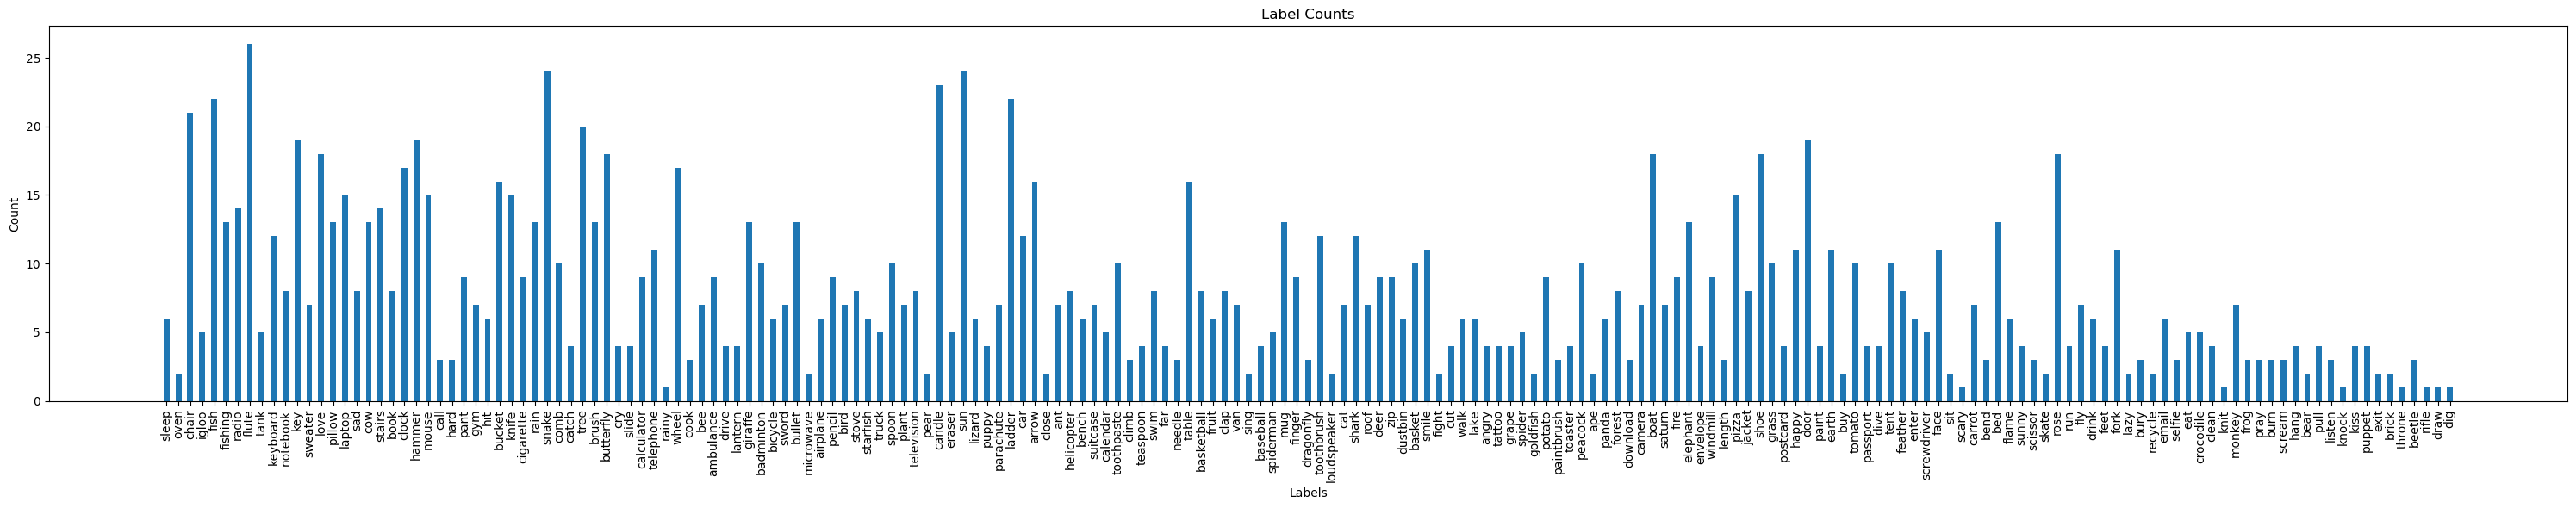

In [238]:
def analyse_data(data):
        label_counts = {}
        for item in data:
            label = item[3]
            if label not in label_counts:
                label_counts[label]=1
            else:
                label_counts[label] += 1

        labels = list(label_counts.keys())
        counts = list(label_counts.values())
        plt.figure(figsize=(30, 6))
        plt.bar(labels, counts, width=0.5)
        plt.xlabel('Labels')
        plt.ylabel('Count')
        plt.title('Label Counts')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
analyse_data(data)

#### Metrics for top 20 combinations of Hyperparameters with greatest Accuracy

In [239]:
knn_classifier=KNN("VIT",9,"Cosine")
encoders=["ResNet","VIT"]
k_vals=range(1,38)
distance_metrics=["Euclidean","Manhattan","Cosine"]
acc=[]
max_acc=0
min_time=10000
max_acc_tupple=None
max_acc_time=None
min_time_tupple=None
for e in encoders:
    for k in k_vals:
        for d in distance_metrics:
            knn_classifier.change_k(k)
            knn_classifier.change_encoder(e)
            knn_classifier.change_distance_metric(d)
            t1=time.time()
            x=knn_classifier.opt_eval(data,0.8)
            t2=time.time()
            time_taken=t2-t1
            v=[x[0],e,k,d]
            acc.append([x,e,k,d])
            if max_acc<x[0]:
                max_acc=x[0]
                max_acc_tupple=v
                max_acc_time=time_taken
            if min_time>time_taken:
                min_time=time_taken
                min_time_tupple=[time_taken,e,k,d]
sorted_list=sorted(acc, key=lambda x: x[0][0], reverse=True)
for i in range(20):
    print("Rank - "+str(i+1))
    print()
    table = PrettyTable()
    table.field_names = ["Metric", "Value"]
    table.add_row(["Accuracy",sorted_list[i][0][0]])
    table.add_row(["Precision",sorted_list[i][0][1]])
    table.add_row(["Recall",sorted_list[i][0][2]])
    table.add_row(["F1 Score (Macro)",sorted_list[i][0][3]])
    table.add_row(["F1 Score (Micro)",sorted_list[i][0][4]])
    table.add_row(["Encoder",sorted_list[i][1]])
    table.add_row(["K",sorted_list[i][2]])
    table.add_row(["Distance Metric",sorted_list[i][3]])
    print(table)
    print("---------------------")
    print()

Rank - 1

+------------------+---------------------+
|      Metric      |        Value        |
+------------------+---------------------+
|     Accuracy     | 0.30666666666666664 |
|    Precision     | 0.49456400081400087 |
|      Recall      |  0.3177960927960928 |
| F1 Score (Macro) |  0.1814753978215517 |
| F1 Score (Micro) | 0.30666666666666664 |
|     Encoder      |         VIT         |
|        K         |          8          |
| Distance Metric  |      Euclidean      |
+------------------+---------------------+
---------------------

Rank - 2

+------------------+---------------------+
|      Metric      |        Value        |
+------------------+---------------------+
|     Accuracy     | 0.30666666666666664 |
|    Precision     |  0.5069132742699621 |
|      Recall      | 0.32691841067637245 |
| F1 Score (Macro) | 0.18635147212083183 |
| F1 Score (Micro) | 0.30666666666666664 |
|     Encoder      |         VIT         |
|        K         |          9          |
| Distance 

#### Triplet of Hyperparameters which give maximum accuracy for KNN

In [240]:
print()
print("Accuracy : "+str(max_acc_tupple[0]))
table = PrettyTable()
table.field_names = ["Hyperparameter", "Value"]
table.add_row(["Encoder",max_acc_tupple[1]])
table.add_row(["K",max_acc_tupple[2]])
table.add_row(["Distance Metric",max_acc_tupple[3]])
print(table)
print()


Accuracy : 0.30666666666666664
+-----------------+-----------+
|  Hyperparameter |   Value   |
+-----------------+-----------+
|     Encoder     |    VIT    |
|        K        |     8     |
| Distance Metric | Euclidean |
+-----------------+-----------+



#### Plot of k vs accuracy for Distance Metric as Euclidean, VIT Encoding and 80:20 Train-Test Split

[0.26, 0.26, 0.27666666666666667, 0.28, 0.28, 0.2733333333333333, 0.2866666666666667, 0.30666666666666664, 0.30666666666666664, 0.30666666666666664, 0.29, 0.27666666666666667, 0.28, 0.2866666666666667, 0.28, 0.27666666666666667, 0.27, 0.27, 0.28, 0.27, 0.26666666666666666, 0.27, 0.26, 0.26666666666666666, 0.26666666666666666, 0.27, 0.26666666666666666, 0.26, 0.26, 0.25666666666666665, 0.25666666666666665, 0.25333333333333335, 0.25, 0.24333333333333335, 0.25, 0.24333333333333335, 0.22333333333333333]


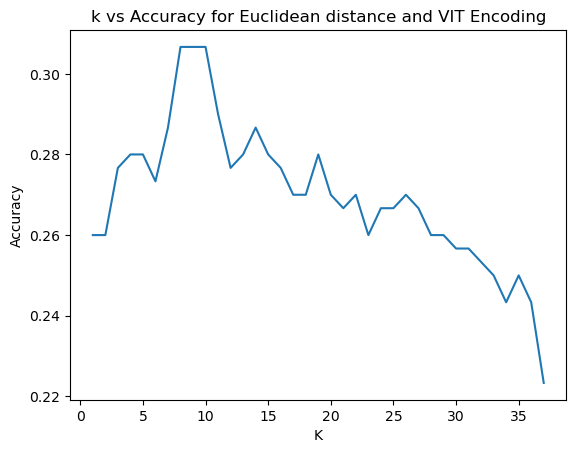

In [241]:
k_vals=range(1,38)
knn_classifier.change_distance_metric("Euclidean")
knn_classifier.change_encoder("VIT")
acc=[]
for k in k_vals:
    knn_classifier.change_k(k)
    rval=knn_classifier.opt_eval(data,0.8)
    acc.append(rval[0])
print(acc)
plt.plot(k_vals, acc)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('k vs Accuracy for Euclidean distance and VIT Encoding')
plt.xticks(rotation=0)
plt.show()

### Inbuilt KNN in sklearn

In [242]:
def skl_eval(data,enc,K,dm,sz):
        np.random.shuffle(data)
        y=data[:,3]
        if enc=="VIT":
            data=data[:,2]
        else:
            data=data[:,1]
        x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=1-sz, random_state=42)
        x_train=[a[0] for a in x_train]
        x_test=[a[0] for a in x_test]
        x_train=np.array(x_train)
        x_test=np.array(x_test)
        knn = KNeighborsClassifier(n_neighbors=K, metric='euclidean')
        if dm=="Manhattan":
            knn = KNeighborsClassifier(n_neighbors=K, metric='manhattan')
        elif dm=="Cosine":
            knn = KNeighborsClassifier(n_neighbors=K, metric='cosine')
        knn.fit(x_train, y_train)
        prediction = knn.predict(x_test)
        accuracy = accuracy_score(y_test, prediction)
        precision = precision_score(y_test, prediction,average='weighted',zero_division=1)
        recall = recall_score(y_test, prediction,average='weighted',zero_division=1)
        f1 = f1_score(y_test, prediction,average='weighted')
        return accuracy,precision,recall,f1

#### Plot of inference time for Sklearn KNN and custom KNN implementation

/Users/akshitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


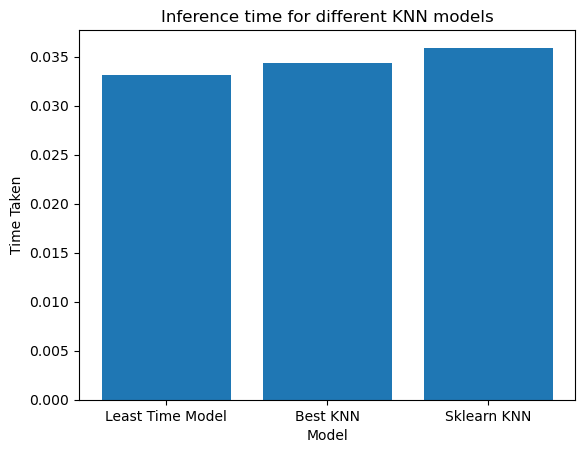

In [243]:
t1=time.time()
skl_eval(data,max_acc_tupple[1],max_acc_tupple[2],max_acc_tupple[3],0.8)
t2=time.time()
sk_time=t2-t1
plt.bar(['Least Time Model','Best KNN','Sklearn KNN'], [min_time,max_acc_time,sk_time])
plt.xlabel('Model')
plt.ylabel('Time Taken')
plt.title('Inference time for different KNN models')
plt.show()

#### Plot of inference time vs train dataset ratio for best KNN model and the default sklearn KNN model

/Users/akshitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/akshitsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

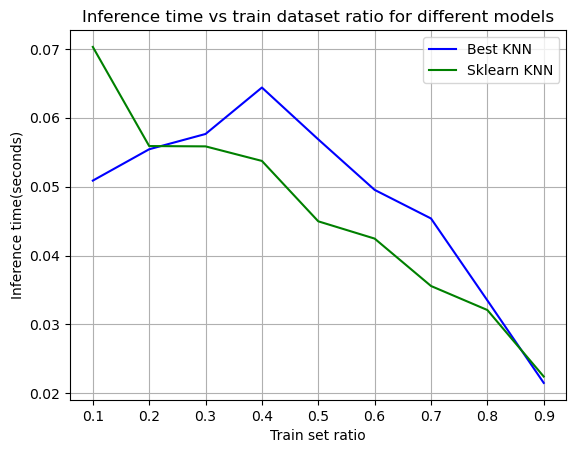

In [244]:
train_set_size=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
data=np.load('data.npy',allow_pickle=True)
knn_classifier=KNN("VIT",9,"Cosine")
net_times=[]
for sz in train_set_size:
    times=[]
    knn_classifier.change_encoder(max_acc_tupple[1])
    knn_classifier.change_k(max_acc_tupple[2])
    knn_classifier.change_distance_metric(max_acc_tupple[3])
    t1=time.time()
    knn_classifier.opt_eval(data,sz)
    t2=time.time()
    times.append(t2-t1)
    t1=time.time()
    skl_eval(data,max_acc_tupple[1],max_acc_tupple[2],max_acc_tupple[3],sz)
    t2=time.time()
    times.append(t2-t1)
    net_times.append(times)
colors=['blue','green']
mod=['Best KNN','Sklearn KNN']
for i in range(2):
    plt.plot(train_set_size, [t[i] for t in net_times], label=mod[i], color=colors[i])
plt.xlabel('Train set ratio')
plt.ylabel('Inference time(seconds)')
plt.title('Inference time vs train dataset ratio for different models')
plt.legend()
plt.grid(True)
plt.show()

## Decision Trees

### Loading Dataset from advertisement.csv File

In [245]:
data=pd.read_csv('advertisement.csv')
x=data.iloc[:, :-1].values
y=data.iloc[:, -1].values

### Dataset Visualization

#### Graph to show Frequency of unique labels in dataset

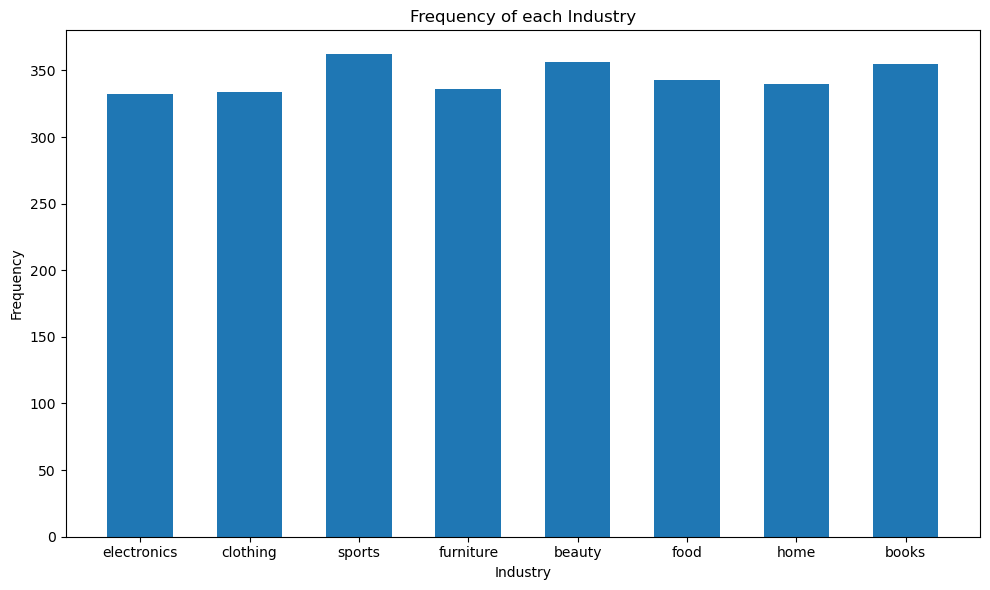

In [246]:
vis=""
for s in y:
    vis+=s
    vis+=" "
words = vis.split()
word_counts = Counter(words)
word_list = list(word_counts.keys())
frequency_list = list(word_counts.values())
plt.figure(figsize=(10, 6))
plt.bar(word_list, frequency_list, width=0.6)
plt.xlabel('Industry')
plt.ylabel('Frequency')
plt.title('Frequency of each Industry')
plt.tight_layout()
plt.show()

#### Graph to show gender distribution in dataset

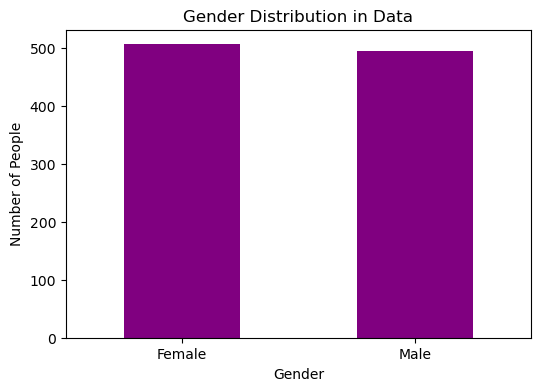

In [247]:
gender_counts = data['gender'].value_counts()
plt.figure(figsize=(6, 4))
gender_counts.plot(kind='bar', color='purple')
plt.xlabel('Gender')
plt.ylabel('Number of People')
plt.title('Gender Distribution in Data')
plt.xticks(rotation=0)
plt.show()

#### Graph to show Distribution of people based on number of children

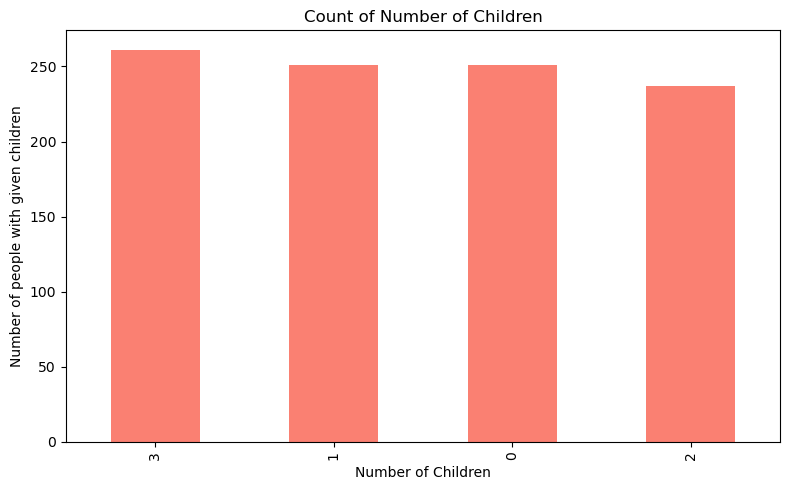

In [248]:
children_counts = data['children'].value_counts()
plt.figure(figsize=(8, 5))
children_counts.plot(kind='bar', color='salmon')
plt.xlabel('Number of Children')
plt.ylabel('Number of people with given children')
plt.title('Count of Number of Children')
plt.tight_layout()
plt.show()

#### Plot of Frequency of Most Bought Items

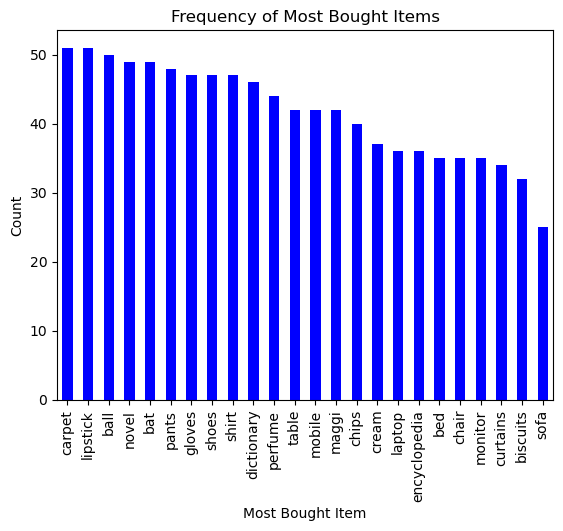

In [249]:
most_counts = data['most bought item'].value_counts()
most_counts.plot(kind='bar', color='blue')
plt.xlabel('Most Bought Item')
plt.ylabel('Count')
plt.title('Frequency of Most Bought Items')
plt.show()

#### 

#### Plot of Occupation vs number of people with that occupation

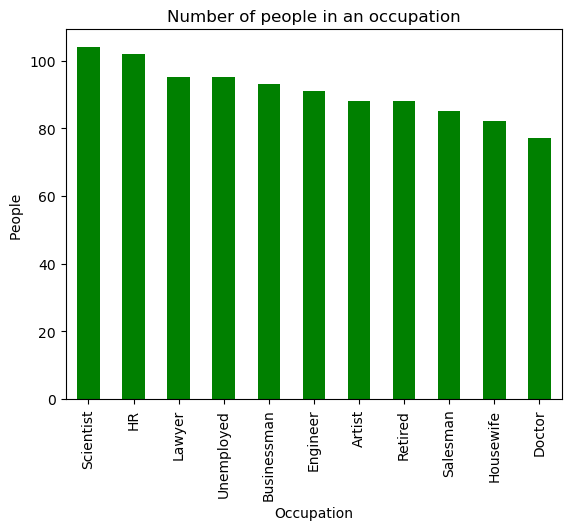

In [250]:
most_counts = data['occupation'].value_counts()
most_counts.plot(kind='bar', color='green')
plt.xlabel('Occupation')
plt.ylabel('People ')
plt.title('Number of people in an occupation')
plt.show()

### Class implementation for MultiOutput Setting in Decision Tree

In [251]:
class DecisionTree_MultiOutput:
    def __init__(self,depth,features,criterion):
        self.max_depth=depth
        self.max_features=features
        self.criterion=criterion
    def set_depth(self,d):
        self.max_depth=d
    def set_features(self,f):
        self.max_features=f
    def set_criterion(self,c):
        self.criterion=c
    def onehot(self,X):
        cols=['gender','education','married','city','occupation','most bought item']
        x_new=pd.get_dummies(X,columns=cols)
        return x_new.values
    def get_words(self,y):
        vis=""
        for s in y:
            vis+=s
            vis+=" "
        words = vis.split()
        word_counts = Counter(words) 
        word_list = list(word_counts.keys())
        uniq_labels=sorted(word_list)
        return {word: index for index, word in enumerate(uniq_labels)}
    def encode_labels(self,y,word_to_index):
        vis=""
        for s in y:
            vis+=s
            vis+=" "
        words = vis.split()
        word_counts = Counter(words) 
        word_list = list(word_counts.keys())
        uniq_labels=sorted(word_list)
        uniq_count=len(uniq_labels)
        word_to_index = {word: index for index, word in enumerate(uniq_labels)}
        vecs=[]
        for spl in y:
            new_label=[0]*uniq_count
            present=spl.split()
            for w in present:
                new_label[word_to_index[w]]=1
            vecs.append(new_label)
        return np.array(vecs)
    def build_tree(self,data):
        y=data.iloc[:,-1].values
        word_to_index=self.get_words(y)
        x=self.onehot(data.iloc[:,:-1])
        y=data.iloc[:,-1].values
        y=self.encode_labels(y,word_to_index)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
        dt_classifier=MultiOutputClassifier(DecisionTreeClassifier(max_depth=self.max_depth,criterion=self.criterion,max_features=self.max_features))
        dt_classifier=dt_classifier.fit(x_train,y_train)
        pred=dt_classifier.predict(x_test)
        accuracy=accuracy_score(y_test,pred)
        f1_macro=f1_score(y_test,pred,average='macro')
        f1_micro=f1_score(y_test,pred,average='micro')
        precision=precision_score(y_test,pred,average='macro',zero_division=1)
        recall=recall_score(y_test,pred,average='macro',zero_division=1)
        conf_mat=np.sum(multilabel_confusion_matrix(y_test,pred),axis=0)
        return accuracy,f1_macro,f1_micro,precision,recall,conf_mat
    def k_fold_func(self,data,train_index,test_index):
        y=data.iloc[:,-1].values
        word_to_index=self.get_words(y)
        x=self.onehot(data.iloc[:,:-1])
        y=self.encode_labels(y,word_to_index)
        x_train=x[np.array(train_index)]
        y_train=y[np.array(train_index)]
        x_test=x[np.array(test_index)]
        y_test=y[np.array(test_index)]
        dt_classifier=DecisionTreeClassifier(max_depth=self.max_depth,criterion=self.criterion,max_features=self.max_features)
        dt_classifier=dt_classifier.fit(x_train,y_train)
        pred=dt_classifier.predict(x_test)
        accuracy=accuracy_score(y_test,pred)
        f1_macro=f1_score(y_test,pred,average='macro')
        f1_micro=f1_score(y_test,pred,average='micro')
        precision=precision_score(y_test,pred,average='macro',zero_division=1)
        recall=recall_score(y_test,pred,average='macro',zero_division=1)
        conf_mat=np.sum(multilabel_confusion_matrix(y_test,pred),axis=0)
        return accuracy,f1_macro,f1_micro,precision,recall,conf_mat

### Metrics for MultiOutput Setting

In [252]:
data=pd.read_csv('advertisement.csv')
Tree_MultiOutput=DecisionTree_MultiOutput(3,3,'entropy')
criterion=['gini','entropy']
max_depth=[3,5,10,20,30]
max_features=[3,5,7,9,11]
lst=[]
lst2=[]
# performing classification for all possible values of hyperparameters and listing top 3 erformers based on F1-Score (macro)
for a in criterion:
    for b in max_depth:
        for c in max_features:
            Tree_MultiOutput.set_criterion(a)
            Tree_MultiOutput.set_depth(b)
            Tree_MultiOutput.set_features(c)
            z=Tree_MultiOutput.build_tree(data)
            lst.append([z,a,b,c])
            lst2.append([z[1],a,b,c])
print("Top 3 best performing set of hyperparameters for MultiOutput Setting are:- ")
print()
sorted_best_f1_macro=sorted(lst2, key=lambda x: x[0], reverse=True)
best_performer=lst2[0]
for i in range(3):
    v=sorted_best_f1_macro[i]
    print("F1 Score (Macro) - "+str(v[0]))
    print()
    table = PrettyTable()
    table.field_names = ["Hyperparameter", "Value"]
    table.add_row(["Criterion",v[1]])
    table.add_row(["Max Depth",v[2]])
    table.add_row(["Max Features",v[3]])
    print(table)
    print("----------------------------")
    print()

Top 3 best performing set of hyperparameters for MultiOutput Setting are:- 

F1 Score (Macro) - 0.25158344036012026

+----------------+-------+
| Hyperparameter | Value |
+----------------+-------+
|   Criterion    |  gini |
|   Max Depth    |   30  |
|  Max Features  |   9   |
+----------------+-------+
----------------------------

F1 Score (Macro) - 0.2345492834570558

+----------------+-------+
| Hyperparameter | Value |
+----------------+-------+
|   Criterion    |  gini |
|   Max Depth    |   30  |
|  Max Features  |   11  |
+----------------+-------+
----------------------------

F1 Score (Macro) - 0.20333827511594887

+----------------+---------+
| Hyperparameter |  Value  |
+----------------+---------+
|   Criterion    | entropy |
|   Max Depth    |    20   |
|  Max Features  |    11   |
+----------------+---------+
----------------------------



In [253]:
# printing metrices for all possible tupples of hyperparameters using prettytable
print("Metrics for All possible triplets of Hyperparameters for Multioutput Setting :- ")
print()
for l in lst:
    print("Criterion : "+str(l[1]))
    print("Max Depth : "+str(l[2]))
    print("Max Features : "+str(l[3]))
    print()
    table = PrettyTable()
    table.field_names = ["Metric", "Value"]
    table.add_row(["Accuracy",l[0][0]])
    table.add_row(["F1 Score (Macro)",l[0][1]])
    table.add_row(["F1 Score (Micro)",l[0][2]])
    table.add_row(["Precision",l[0][3]])
    table.add_row(["Recall",l[0][4]])
    print(table)
    print()
    print("Confusion Matrix (Pooled) :-")
    table2 = PrettyTable()
    table2.field_names = ["", "Predicted 0", "Predicted 1"]
    table2.add_row(["Actual 0", l[0][5][0, 0], l[0][5][0, 1]])
    table2.add_row(["Actual 1", l[0][5][1, 0], l[0][5][1, 1]])
    print(table2)
    print()
    print("----------------------------")
    print()

Metrics for All possible triplets of Hyperparameters for Multioutput Setting :- 

Criterion : gini
Max Depth : 3
Max Features : 3

+------------------+-------+
|      Metric      | Value |
+------------------+-------+
|     Accuracy     |  0.0  |
| F1 Score (Macro) |  0.0  |
| F1 Score (Micro) |  0.0  |
|    Precision     |  1.0  |
|      Recall      |  0.0  |
+------------------+-------+

Confusion Matrix (Pooled) :-
+----------+-------------+-------------+
|          | Predicted 0 | Predicted 1 |
+----------+-------------+-------------+
| Actual 0 |     1073    |      0      |
| Actual 1 |     527     |      0      |
+----------+-------------+-------------+

----------------------------

Criterion : gini
Max Depth : 3
Max Features : 5

+------------------+-------+
|      Metric      | Value |
+------------------+-------+
|     Accuracy     |  0.0  |
| F1 Score (Macro) |  0.0  |
| F1 Score (Micro) |  0.0  |
|    Precision     | 0.875 |
|      Recall      |  0.0  |
+------------------+

#### K-Fold Validation on best performing model for MultiOutput Setting

In [254]:
ks=[2,3,4,5,6,7,8,9,10]
# setting class attributes with the hyperparameters which gave best F1 Score
Tree_MultiOutput.set_criterion(best_performer[1])
Tree_MultiOutput.set_depth(best_performer[2])
Tree_MultiOutput.set_features(best_performer[3])
f1_macro_lst=[]
# performing k-fold validation on different values of k to check the best possible value of k based on highest F1-Score (macro)
for k in ks:
     kf = KFold(n_splits=k, shuffle=True, random_state=42)
     metrics=[]
     for i,(train_index, test_index) in enumerate(kf.split(data)):
          z=Tree_MultiOutput.k_fold_func(data,train_index,test_index)
          metrics.append(np.array(z,dtype=list))
     metrics=np.array(metrics)
     accuracy=np.mean(metrics[:,0])
     f1_macro=np.mean(metrics[:,1])
     f1_micro=np.mean(metrics[:,2])
     precision=np.mean(metrics[:,3])
     recall=np.mean(metrics[:,4])
     # printing metrics for the given value of k after performing validation and taking mean of metrices
     table = PrettyTable()
     print("Value of K: "+str(k))
     table.field_names = ["Metric", "Value"]
     table.add_row(["Accuracy",accuracy])
     table.add_row(["F1 Score (Macro)",f1_macro])
     table.add_row(["F1 Score (Micro)",f1_micro])
     table.add_row(["Precision",precision])
     table.add_row(["Recall",recall])
     print(table)
     print("------------------------")
     f1_macro_lst.append([f1_macro,k])
f1_macro_lst=sorted(f1_macro_lst,key=lambda x:x[0],reverse=True)
print("Best K (based on highest F1_Macro Score : )"+str(f1_macro_lst[0][1]))

Value of K: 2
+------------------+----------------------+
|      Metric      |        Value         |
+------------------+----------------------+
|     Accuracy     |        0.005         |
| F1 Score (Macro) | 0.018035498110056846 |
| F1 Score (Micro) | 0.018560098877330313 |
|    Precision     |  0.7708333333333333  |
|      Recall      | 0.010000852389249491 |
+------------------+----------------------+
------------------------
Value of K: 3
+------------------+----------------------+
|      Metric      |        Value         |
+------------------+----------------------+
|     Accuracy     | 0.001001001001001001 |
| F1 Score (Macro) | 0.00853018372703412  |
| F1 Score (Micro) | 0.009249377445748844 |
|    Precision     |         1.0          |
|      Recall      | 0.004751461988304093 |
+------------------+----------------------+
------------------------
Value of K: 4
+------------------+-------+
|      Metric      | Value |
+------------------+-------+
|     Accuracy     |  0.0  |


### Class implementation for PowerSet Setting in Decision Tree

In [255]:
class DecisionTree_PowerSet:
    def __init__(self,depth,features,criterion):
        self.max_depth=depth
        self.max_features=features
        self.criterion=criterion
    def set_depth(self,d):
        self.max_depth=d
    def set_features(self,f):
        self.max_features=f
    def set_criterion(self,c):
        self.criterion=c
    def onehot(self,X):
        cols=['gender','education','married','city','occupation','most bought item']
        x_new=pd.get_dummies(X,columns=cols)
        return x_new.values
    def encode_labels(self,y,word_to_index):
        vecs=[]
        for spl in y:
            va=0
            tup=[0]*256
            present=spl.split()
            for w in present:
                va+=2**word_to_index[w]
            tup[va]=1
            vecs.append(tup)
        return np.array(vecs)
    def get_words(self,y):
        vis=""
        for s in y:
            vis+=s
            vis+=" "
        words = vis.split()
        word_counts = Counter(words) 
        word_list = list(word_counts.keys())
        uniq_labels=sorted(word_list)
        return {word: index for index, word in enumerate(uniq_labels)}
    def build_tree(self,data):
        y=data.iloc[:,-1].values
        word_to_index=self.get_words(y)
        x=self.onehot(data.iloc[:,:-1])
        y=self.encode_labels(y,word_to_index)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
        dt_classifier=DecisionTreeClassifier(max_depth=self.max_depth,criterion=self.criterion,max_features=self.max_features)
        dt_classifier=dt_classifier.fit(x_train,y_train)
        pred=dt_classifier.predict(x_test)
        accuracy=accuracy_score(y_test,pred)
        f1_macro=f1_score(y_test,pred,average='macro',zero_division=1)
        f1_micro=f1_score(y_test,pred,average='micro',zero_division=1)
        precision=precision_score(y_test,pred,average='macro',zero_division=1)
        recall=recall_score(y_test,pred,average='macro',zero_division=1)
        conf_mat=np.sum(multilabel_confusion_matrix(y_test,pred),axis=0)
        return accuracy,f1_macro,f1_micro,precision,recall,conf_mat
    def k_fold_func(self,data,train_index,test_index):
        y=data.iloc[:,-1].values
        word_to_index=self.get_words(y)
        x=self.onehot(data.iloc[:,:-1])
        y=self.encode_labels(y,word_to_index)
        x_train=x[np.array(train_index)]
        y_train=y[np.array(train_index)]
        x_test=x[np.array(test_index)]
        y_test=y[np.array(test_index)]
        dt_classifier=DecisionTreeClassifier(max_depth=self.max_depth,criterion=self.criterion,max_features=self.max_features)
        dt_classifier=dt_classifier.fit(x_train,y_train)
        pred=dt_classifier.predict(x_test)
        accuracy=accuracy_score(y_test,pred)
        f1_macro=f1_score(y_test,pred,average='macro',zero_division=1)
        f1_micro=f1_score(y_test,pred,average='micro',zero_division=1)
        precision=precision_score(y_test,pred,average='macro',zero_division=1)
        recall=recall_score(y_test,pred,average='macro',zero_division=1)
        conf_mat=np.sum(multilabel_confusion_matrix(y_test,pred),axis=0)
        return accuracy,f1_macro,f1_micro,precision,recall,conf_mat

### Metrics for PowerSet Setting

In [256]:
Tree_PowerSet=DecisionTree_PowerSet(3,3,'entropy')
criterion=['gini','entropy']
max_depth=[3,5,10,20,30]
max_features=[3,5,7,9,11]
lst=[]
lst2=[]
# performing classification for all possible values of hyperparameters and listing top 3 erformers based on F1-Score (macro)
for a in criterion:
    for b in max_depth:
        for c in max_features:
            Tree_PowerSet.set_criterion(a)
            Tree_PowerSet.set_depth(b)
            Tree_PowerSet.set_features(c)
            z=Tree_PowerSet.build_tree(data)
            lst.append([z,a,b,c])
            lst2.append([z[1],a,b,c])
print("Top 3 best performing set of hyperparameters for PowerSet Setting are:- ")
print()
sorted_best_f1_macro=sorted(lst2, key=lambda x: x[0], reverse=True)
best_performer=lst2[0]
for i in range(3):
    v=sorted_best_f1_macro[i]
    print("F1 Score (Macro) - "+str(v[0]))
    print()
    table = PrettyTable()
    table.field_names = ["Hyperparameter", "Value"]
    table.add_row(["Criterion",v[1]])
    table.add_row(["Max Depth",v[2]])
    table.add_row(["Max Features",v[3]])
    print(table)
    print("----------------------------")
    print()

Top 3 best performing set of hyperparameters for PowerSet Setting are:- 

F1 Score (Macro) - 0.5859375

+----------------+-------+
| Hyperparameter | Value |
+----------------+-------+
|   Criterion    |  gini |
|   Max Depth    |   3   |
|  Max Features  |   3   |
+----------------+-------+
----------------------------

F1 Score (Macro) - 0.5859375

+----------------+-------+
| Hyperparameter | Value |
+----------------+-------+
|   Criterion    |  gini |
|   Max Depth    |   3   |
|  Max Features  |   5   |
+----------------+-------+
----------------------------

F1 Score (Macro) - 0.5859375

+----------------+-------+
| Hyperparameter | Value |
+----------------+-------+
|   Criterion    |  gini |
|   Max Depth    |   3   |
|  Max Features  |   7   |
+----------------+-------+
----------------------------



In [257]:
# printing metrices for all possible tupples of hyperparameters using prettytable
print("Metrics for All possible triplets of Hyperparameters for PowerSet Setting :- ")
print()
for l in lst:
    print("Criterion : "+str(l[1]))
    print("Max Depth : "+str(l[2]))
    print("Max Features : "+str(l[3]))
    print()
    table = PrettyTable()
    table.field_names = ["Metric", "Value"]
    table.add_row(["Accuracy",l[0][0]])
    table.add_row(["F1 Score (Macro)",l[0][1]])
    table.add_row(["F1 Score (Micro)",l[0][2]])
    table.add_row(["Precision",l[0][3]])
    table.add_row(["Recall",l[0][4]])
    print(table)
    print()
    print("Confusion Matrix :-")
    table2 = PrettyTable()
    table2.field_names = ["", "Predicted 0", "Predicted 1"]
    table2.add_row(["Actual 0", l[0][5][0, 0], l[0][5][0, 1]])
    table2.add_row(["Actual 1", l[0][5][1, 0], l[0][5][1, 1]])
    print(table2)
    print()
    print("----------------------------")
    print()

Metrics for All possible triplets of Hyperparameters for PowerSet Setting :- 

Criterion : gini
Max Depth : 3
Max Features : 3

+------------------+-----------+
|      Metric      |   Value   |
+------------------+-----------+
|     Accuracy     |    0.0    |
| F1 Score (Macro) | 0.5859375 |
| F1 Score (Micro) |    0.0    |
|    Precision     |    1.0    |
|      Recall      | 0.5859375 |
+------------------+-----------+

Confusion Matrix :-
+----------+-------------+-------------+
|          | Predicted 0 | Predicted 1 |
+----------+-------------+-------------+
| Actual 0 |    51000    |      0      |
| Actual 1 |     200     |      0      |
+----------+-------------+-------------+

----------------------------

Criterion : gini
Max Depth : 3
Max Features : 5

+------------------+-----------+
|      Metric      |   Value   |
+------------------+-----------+
|     Accuracy     |    0.0    |
| F1 Score (Macro) | 0.5859375 |
| F1 Score (Micro) |    0.0    |
|    Precision     |    1.0   

#### K-Fold Validation on best performing model for PowerSet Setting

In [258]:
ks=[2,3,4,5,6,7,8,9,10]
# setting class attributes with the hyperparameters which gave best F1 Score
Tree_PowerSet.set_criterion(best_performer[1])
Tree_PowerSet.set_depth(best_performer[2])
Tree_PowerSet.set_features(best_performer[3])
f1_macro_lst=[]
max_f1=-1
# performing k-fold validation on different values of k to check the best possible value of k based on highest F1-Score (macro)
for k in ks:
     kf = KFold(n_splits=k, shuffle=True, random_state=42)
     metrics=[]
     for i,(train_index, test_index) in enumerate(kf.split(data)):
          z=Tree_PowerSet.k_fold_func(data,train_index,test_index)
          metrics.append(np.array(z,dtype=list))
     metrics = np.array(metrics)
     accuracy=np.mean(metrics[:,0])
     f1_macro=np.mean(metrics[:,1])
     f1_micro=np.mean(metrics[:,2])
     precision=np.mean(metrics[:,3])
     recall=np.mean(metrics[:,4])
     # printing metrics for the given value of k after performing validation and taking mean of metrices
     table = PrettyTable()
     print("Value of K: "+str(k))
     table.field_names = ["Metric", "Value"]
     table.add_row(["Accuracy",accuracy])
     table.add_row(["F1 Score (Macro)",f1_macro])
     table.add_row(["F1 Score (Micro)",f1_micro])
     table.add_row(["Precision",precision])
     table.add_row(["Recall",recall])
     print(table)
     print("------------------------")
     f1_macro_lst.append([f1_macro,k])
f1_macro_lst=sorted(f1_macro_lst,key=lambda x:x[0],reverse=True)
print("Best K (based on highest F1_Macro Score) :- "+str(f1_macro_lst[0][1]))

Value of K: 2
+------------------+----------+
|      Metric      |  Value   |
+------------------+----------+
|     Accuracy     |   0.0    |
| F1 Score (Macro) | 0.359375 |
| F1 Score (Micro) |   0.0    |
|    Precision     |   1.0    |
|      Recall      | 0.359375 |
+------------------+----------+
------------------------
Value of K: 3
+------------------+------------+
|      Metric      |   Value    |
+------------------+------------+
|     Accuracy     |    0.0     |
| F1 Score (Macro) | 0.45703125 |
| F1 Score (Micro) |    0.0     |
|    Precision     |    1.0     |
|      Recall      | 0.45703125 |
+------------------+------------+
------------------------
Value of K: 4
+------------------+--------------+
|      Metric      |    Value     |
+------------------+--------------+
|     Accuracy     |     0.0      |
| F1 Score (Macro) | 0.5185546875 |
| F1 Score (Micro) |     0.0      |
|    Precision     |     1.0      |
|      Recall      | 0.5185546875 |
+------------------+------